# Lab 4
### Zespół
- Krzysztof Kordal
- Szymon Szewczyk
- Łukasz Szyszka

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Przykładowe F
def F(u):
    x, y = u
    F1 = x**2 + y**2
    F2 = (x - 1)**2 + y**2
    return np.array([F1, F2])

### Skalaryzacja przez funkcję liniową

In [7]:
def scalarization_linear(v, lambdas):
    """
    Skalaryzacja przez funkcję liniową: S1(v, λ) = sum(λ_i * v_i) dla λ > 0
    :param v: Wektor kryteriów (np. [v1, v2, ..., vN])
    :param lambdas: Wektor wag λ (np. [λ1, λ2, ..., λN]), gdzie λ > 0
    :return: Wynik skalaryzacji
    """
    return np.dot(lambdas, v)

### metoda eps-ograniczeń,

In [8]:
def epsilon_constraints(u, a, j, F):
    """
    Metoda ε-ograniczeń: S2(u, a, j) = Fj(u) z ograniczeniami Fi(u) ≤ ai, dla i ≠ j
    :param u: Wektor zmiennych decyzyjnych
    :param a: Wektor ograniczeń ε dla funkcji kryterialnych Fi(u)
    :param j: Indeks funkcji Fj, którą optymalizujemy
    :param F: Lista funkcji celu F = [F1, F2, ..., FN]
    :return: Wynik funkcji Fj(u), jeśli spełnia ograniczenia
    """
    for i, func in enumerate(F):
        if i != j and func(u) > a[i]:
            return float('inf')  # Odrzucenie punktu, jeśli narusza ograniczenia
    return F[j](u)  # Zwróć wartość optymalizowanego kryterium Fj(u)

### skalaryzacja przez odległość od wybranego punktu dominującego x

In [9]:
def scalarization_distance(u, x, lambd, p, F):
    """
    Skalaryzacja przez odległość: S3(u, x, λ, p) = ||F(u) - x||λ,p
    :param u: Wektor zmiennych decyzyjnych
    :param x: Punkt dominujący
    :param lambd: Parametr skalaryzacji λ > 0
    :param p: Parametr odległości (p ≥ 1 lub p = ∞ dla metryki Czebyszewa)
    :param F: Funkcja wektorowa celu
    :return: Odległość ||F(u) - x||λ,p
    """
    diff = np.abs(F(u) - x) ** lambd  # Wektor różnic |F(u) - x| podniesiony do potęgi λ
    if p == np.inf:
        return np.max(diff)  # Metryka Czebyszewa
    else:
        return np.sum(diff ** (1 / p))  # Odległość w metryce p

### Dalsza część

In [ ]:
def generate_decision_space(bounds=(-1, 1), steps=20):
    x_values = np.linspace(bounds[0], bounds[1], steps)
    y_values = np.linspace(bounds[0], bounds[1], steps)
    U = [(x, y) for x in x_values for y in y_values if x**2 + y**2 <= 1]
    return U


# Funkcje celu dla metody ograniczeń S2
F_list = [lambda u: F(u)[0], lambda u: F(u)[1]]

# Parametry skalaryzacji
lambdas = np.array([0.5, 0.5])
a = [1, 1]
j = 0
x_dom = np.array([0.5, 0.5])
lambd = 1
p = 2

# Generowanie przestrzeni decyzyjnej
U = generate_decision_space()

[(-0.8947368421052632, -0.368421052631579), (-0.8947368421052632, -0.26315789473684215), (-0.8947368421052632, -0.1578947368421053), (-0.8947368421052632, -0.052631578947368474), (-0.8947368421052632, 0.05263157894736836), (-0.8947368421052632, 0.1578947368421053), (-0.8947368421052632, 0.26315789473684204), (-0.8947368421052632, 0.36842105263157876), (-0.7894736842105263, -0.5789473684210527), (-0.7894736842105263, -0.4736842105263158), (-0.7894736842105263, -0.368421052631579), (-0.7894736842105263, -0.26315789473684215), (-0.7894736842105263, -0.1578947368421053), (-0.7894736842105263, -0.052631578947368474), (-0.7894736842105263, 0.05263157894736836), (-0.7894736842105263, 0.1578947368421053), (-0.7894736842105263, 0.26315789473684204), (-0.7894736842105263, 0.36842105263157876), (-0.7894736842105263, 0.4736842105263157), (-0.7894736842105263, 0.5789473684210527), (-0.6842105263157895, -0.6842105263157895), (-0.6842105263157895, -0.5789473684210527), (-0.6842105263157895, -0.473684

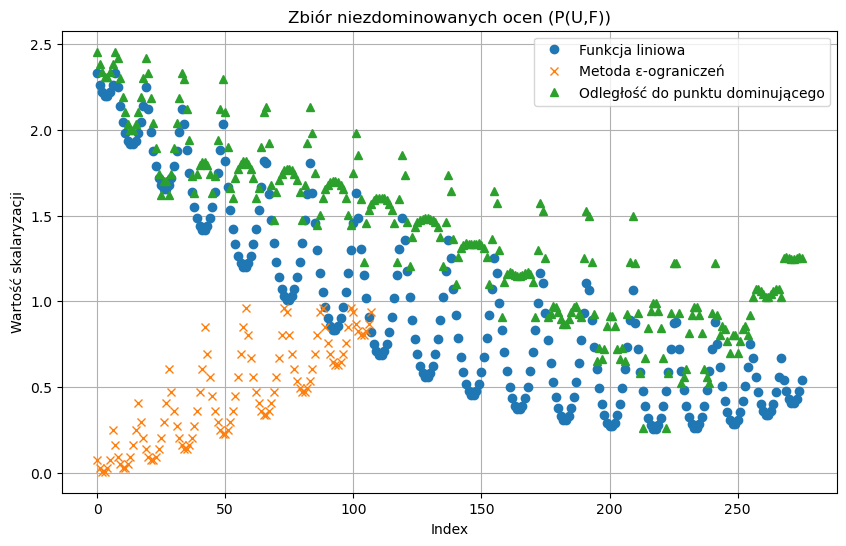

In [14]:
def generate_decision_space(bounds=(-1, 1), steps=20):
    x_values = np.linspace(bounds[0], bounds[1], steps)
    y_values = np.linspace(bounds[0], bounds[1], steps)
    U = [(x, y) for x in x_values for y in y_values if x**2 + y**2 <= 1]
    return U

# Funkcje celu dla metody ograniczeń S2
F_list = [lambda u: F(u)[0], lambda u: F(u)[1]]

# Parametry skalaryzacji
lambdas = np.array([0.5, 0.5])
a = [1, 1]
j = 0
x_dom = np.array([0.5, 0.5])
lambd = 1
p = 2

# Generowanie przestrzeni decyzyjnej
U = generate_decision_space()
print(U)

# Obliczanie dla trzech metod skalaryzacji
P_U_F_linear = []
P_U_F_epsilon = []
P_U_F_distance = []

# Skalaryzacja przez funkcję liniową
for u in U:
    P_U_F_linear.append(scalarization_linear(F(u), lambdas))

# Metoda epsilon-constraints
for u in U:
    result = epsilon_constraints(u, a, j, F_list)
    if result != float('inf'):
        P_U_F_epsilon.append(result)

# Skalaryzacja przez odległość
for u in U:
    P_U_F_distance.append(scalarization_distance(u, x_dom, lambd, p, F))

# Przekształcenie list do tablic numpy
P_U_F_linear = np.array(P_U_F_linear)
P_U_F_epsilon = np.array(P_U_F_epsilon)
P_U_F_distance = np.array(P_U_F_distance)

# Wizualizacja wyników
plt.figure(figsize=(10, 6))

# Zbiór niezdominowanych ocen (P(U,F))
plt.plot(P_U_F_linear, label="Funkcja liniowa", marker='o', linestyle='None')
plt.plot(P_U_F_epsilon, label="Metoda ε-ograniczeń", marker='x', linestyle='None')
plt.plot(P_U_F_distance, label="Odległość do punktu dominującego", marker='^', linestyle='None')

plt.title("Zbiór niezdominowanych ocen (P(U,F))")
plt.xlabel("Index")
plt.ylabel("Wartość skalaryzacji")
plt.legend()
plt.grid()
plt.show()

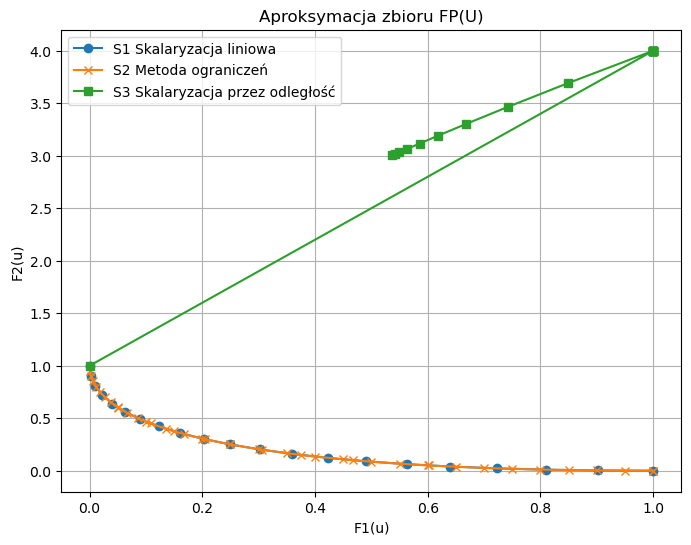

In [3]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Definiujemy funkcje kryterialne F1 i F2
def F(u):
    x, y = u
    F1 = x**2 + y**2
    F2 = (x - 1)**2 + y**2
    return np.array([F1, F2])

# Definiujemy skalaryzację liniową S1
def scalarization_S1(u, lambdas):
    F_values = F(u)
    return np.dot(lambdas, F_values)

# Definiujemy skalaryzację przez odległość S3
def scalarization_S3(u, x_dom, lambdas, p):
    F_values = F(u)
    diff = lambdas * (F_values - x_dom)
    if p == np.inf:
        return np.max(np.abs(diff))
    else:
        return np.linalg.norm(diff, ord=p)

# Definiujemy obszar dopuszczalny U: kwadrat [-1, 1] x [-1, 1]
bounds = [(-1, 1), (-1, 1)]

# Krok rho do zmiany parametrów skalaryzacji
rho = 0.05
lambda_values = np.arange(0, 1 + rho, rho)
lambda_values = np.clip(lambda_values, 0, 1)  # Upewniamy się, że wartości są w przedziale [0,1]
solutions_S1 = []
solutions_S2 = []
solutions_S3 = []

# Skalaryzacja liniowa S1
for lambda1 in lambda_values:
    lambda2 = 1 - lambda1
    if lambda1 == 0 and lambda2 == 0:
        continue
    lambdas = np.array([lambda1, lambda2])
    # Punkt startowy optymalizacji
    x0 = np.array([0, 0])
    res = minimize(scalarization_S1, x0, args=(lambdas,), bounds=bounds)
    if res.success:
        u_opt = res.x
        F_opt = F(u_opt)
        solutions_S1.append(F_opt)

# Skalaryzacja przez odległość S3
# Definiujemy punkt dominujący x_dom
x_dom = np.array([3, 3])
p = 2  # Norma Euklidesowa
for lambda1 in lambda_values:
    lambda2 = 1 - lambda1
    if lambda1 == 0 and lambda2 == 0:
        continue
    lambdas = np.array([lambda1, lambda2])
    x0 = np.array([0, 0])
    res = minimize(scalarization_S3, x0, args=(x_dom, lambdas, p), bounds=bounds)
    if res.success:
        u_opt = res.x
        F_opt = F(u_opt)
        solutions_S3.append(F_opt)

# Skalaryzacja za pomocą metody ograniczeń S2
# Minimalizujemy F1(u) z ograniczeniem F2(u) ≤ a2
a2_values = np.arange(0, 5 + rho, rho)
for a2 in a2_values:
    # Definiujemy ograniczenie F2(u) ≤ a2
    def constraint(u):
        return a2 - F(u)[1]  # Ograniczenie nierównościowe: a2 - F2(u) ≥ 0

    cons = {'type': 'ineq', 'fun': constraint}
    x0 = np.array([0, 0])
    res = minimize(lambda u: F(u)[0], x0, bounds=bounds, constraints=cons)
    if res.success:
        u_opt = res.x
        F_opt = F(u_opt)
        solutions_S2.append(F_opt)

# Dodatkowo, minimalizujemy F2(u) z ograniczeniem F1(u) ≤ a1
a1_values = np.arange(0, 2 + rho, rho)
for a1 in a1_values:
    # Definiujemy ograniczenie F1(u) ≤ a1
    def constraint(u):
        return a1 - F(u)[0]  # Ograniczenie nierównościowe: a1 - F1(u) ≥ 0

    cons = {'type': 'ineq', 'fun': constraint}
    x0 = np.array([0, 0])
    res = minimize(lambda u: F(u)[1], x0, bounds=bounds, constraints=cons)
    if res.success:
        u_opt = res.x
        F_opt = F(u_opt)
        solutions_S2.append(F_opt)

# Konwersja list na tablice numpy i usunięcie duplikatów
solutions_S1 = np.array(solutions_S1)
solutions_S2 = np.array(solutions_S2)
solutions_S3 = np.array(solutions_S3)

# Usunięcie duplikatów w rozwiązaniach S2
solutions_S2 = np.unique(solutions_S2, axis=0)

# Wizualizacja wyników
plt.figure(figsize=(8, 6))
plt.plot(solutions_S1[:, 0], solutions_S1[:, 1], 'o-', label='S1 Skalaryzacja liniowa')
plt.plot(solutions_S2[:, 0], solutions_S2[:, 1], 'x-', label='S2 Metoda ograniczeń')
plt.plot(solutions_S3[:, 0], solutions_S3[:, 1], 's-', label='S3 Skalaryzacja przez odległość')
plt.xlabel('F1(u)')
plt.ylabel('F2(u)')
plt.title('Aproksymacja zbioru FP(U)')
plt.legend()
plt.grid(True)
plt.show()